In [1]:
import scipy.io as sio
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import pathlib  # pathlib is in standard library
import pandas as pd

batch_size = 32
img_height = 224
img_width = 224

directory_train = "../input/shanghaitech/ShanghaiTech/part_B/train_data/images/" 
directory_test = "../input/shanghaitech/ShanghaiTech/part_B/test_data/images/"
directory_mat_train = "../input/shanghaitech/ShanghaiTech/part_B/train_data/ground-truth/"
directory_mat_test = "../input/shanghaitech/ShanghaiTech/part_B/test_data/ground-truth/"
mat_path_ds_train = tf.data.Dataset.list_files(str(pathlib.Path(directory_mat_train + "*.mat")), seed=0)
mat_path_ds_test = tf.data.Dataset.list_files(str(pathlib.Path(directory_mat_test + "*.mat")), seed=0)

In [2]:
count_train_l = []
file_path_train_l = []
for mat_path in mat_path_ds_train.as_numpy_iterator():
    mat_contents = sio.loadmat(mat_path)
    count = mat_contents['image_info'][0][0][0][0][0].shape[0]
    id_img = int(str(mat_path).split('/')[-1].split('.')[0].split('_')[-1])
    file_path = directory_train + 'IMG_'+str(id_img)+'.jpg'
    count_train_l.append(count)
    file_path_train_l.append(file_path)
    
count_test_l = []
file_path_test_l = []
for mat_path in mat_path_ds_test.as_numpy_iterator():
    mat_contents = sio.loadmat(mat_path)
    count = mat_contents['image_info'][0][0][0][0][0].shape[0]
    id_img = int(str(mat_path).split('/')[-1].split('.')[0].split('_')[-1])
    file_path = directory_test + 'IMG_'+str(id_img)+'.jpg'
    count_test_l.append(count)
    file_path_test_l.append(file_path)

In [3]:
print(f'training n. samples:{len(count_train_l)}')
print(f'test n. samples:{len(count_test_l)}')

training n. samples:400
test n. samples:316


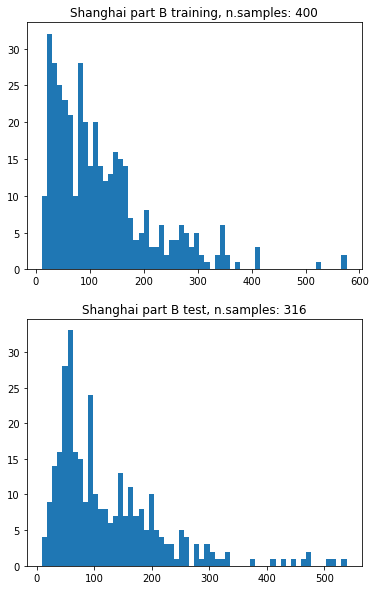

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

hist_fig = plt.figure(figsize=(6,10))

plt.subplot(2,1,1)
_ = plt.hist(count_train_l,bins=60)
_ = plt.title('Shanghai part B training, n.samples: '+str(len(file_path_train_l)))
plt.subplot(2,1,2)
_ = plt.hist(count_test_l,bins=60)
_ = plt.title('Shanghai part B test, n.samples: '+str(len(file_path_test_l)))

plt.show()
_ = hist_fig.savefig('shanghai part B dataset hist.png')

In [5]:
def process_path(file_path, count):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    
    return image, count

train_ds = tf.data.Dataset.from_tensor_slices((file_path_train_l, count_train_l))
train_ds = train_ds.map(process_path)

test_ds = tf.data.Dataset.from_tensor_slices((file_path_test_l, count_test_l))
test_ds = test_ds.map(process_path)

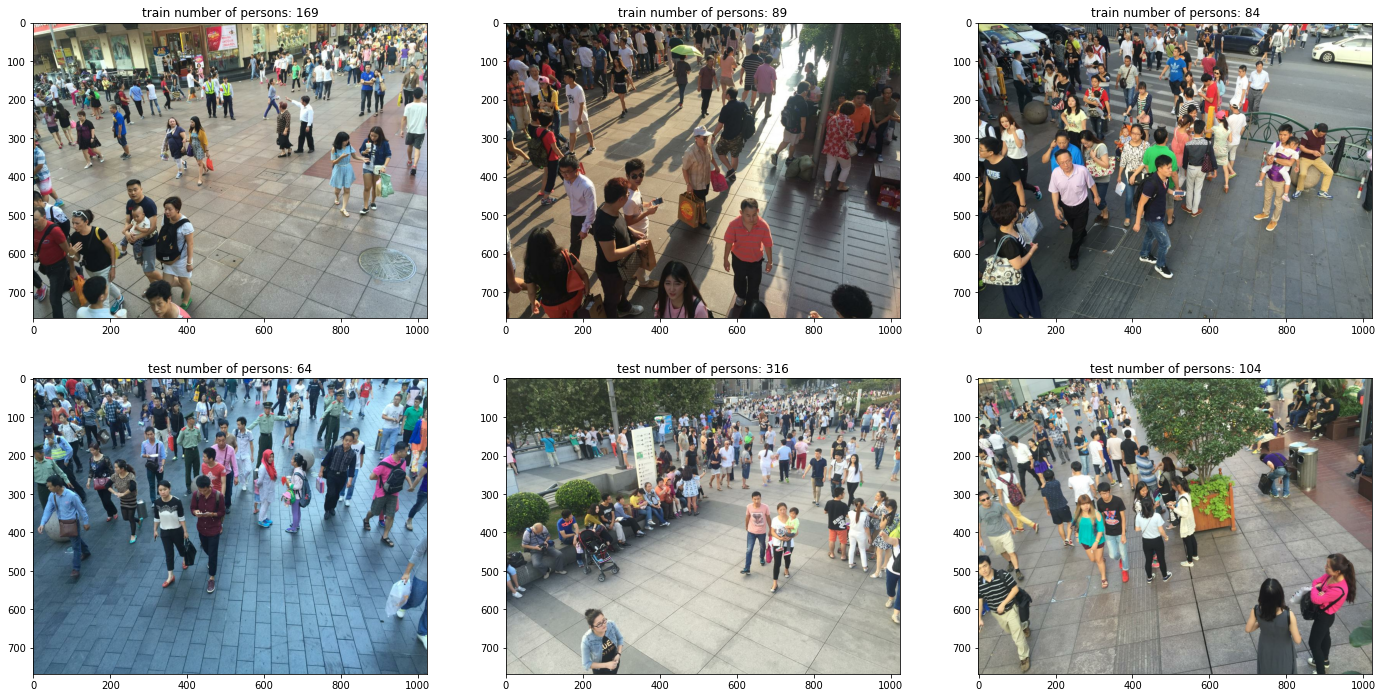

In [6]:
fig = plt.figure(figsize=(24,12))
for i, sample in enumerate(train_ds.take(3).as_numpy_iterator()):
    image = sample[0]
    _ = plt.subplot(2,3,i+1)
    _ = plt.imshow(image)
    _ = plt.title('train number of persons: '+ str(sample[1]))
    
for i, sample in enumerate(test_ds.take(3).as_numpy_iterator()):
    image = sample[0]
    _ = plt.subplot(2,3,i+4)
    _ = plt.imshow(image)
    _ = plt.title('test number of persons: '+ str(sample[1]))
plt.show()

In [7]:
resize_layer = tf.keras.layers.experimental.preprocessing.Resizing(height=img_height, width=img_width)
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)
flip_layer = tf.keras.layers.experimental.preprocessing.RandomFlip()
contrast_layer = tf.keras.layers.experimental.preprocessing.RandomContrast(0.2)
                                                                            
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda image,count: (normalization_layer((resize_layer(image))), count)).cache('./shanghai_training')
train_ds = train_ds.shuffle(buffer_size=100).batch(batch_size).map(lambda image,count: (contrast_layer(flip_layer(image)),count),
                                                                    num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda image,count: (normalization_layer((resize_layer(image))), count)).cache('./shanghai_test').batch(batch_size)

In [8]:
import sys
sys.path.append("../input/tempppp/")
from DenseNet import DenseNet121
model_121 = DenseNet121( input_shape = (img_height,img_width,3),
                                            include_top=False,
                                            pooling='avg',
                                          weights='imagenet'
                                         )
output = tf.keras.layers.Dense(1,
                               activation='relu',kernel_regularizer='l2')(model_121.output)
model_121 = tf.keras.Model(inputs=model_121.input, outputs=output)

29089792/29084464 [==============================] - 0s 0us/step


In [9]:
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath='./best_DenseNet121.h5', monitor='mae', verbose=1, save_best_only=True,
                save_weights_only=True, mode='min')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=1e-6, verbose=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model_121.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
hist_121 = model_121.fit(train_ds,
                    epochs=200, verbose=2, callbacks=[ckpt_callback, reduce_lr])

Epoch 1/200
13/13 - 24s - loss: 21130.3242 - mae: 115.3579

Epoch 00001: mae improved from inf to 115.35794, saving model to ./best_DenseNet121.h5
Epoch 2/200
13/13 - 2s - loss: 17598.1133 - mae: 106.3623

Epoch 00002: mae improved from 115.35794 to 106.36234, saving model to ./best_DenseNet121.h5
Epoch 3/200
13/13 - 2s - loss: 15573.3633 - mae: 101.2169

Epoch 00003: mae improved from 106.36234 to 101.21690, saving model to ./best_DenseNet121.h5
Epoch 4/200
13/13 - 2s - loss: 13796.2930 - mae: 95.1299

Epoch 00004: mae improved from 101.21690 to 95.12993, saving model to ./best_DenseNet121.h5
Epoch 5/200
13/13 - 2s - loss: 11997.1133 - mae: 90.4852

Epoch 00005: mae improved from 95.12993 to 90.48522, saving model to ./best_DenseNet121.h5
Epoch 6/200
13/13 - 2s - loss: 10599.7529 - mae: 84.2173

Epoch 00006: mae improved from 90.48522 to 84.21732, saving model to ./best_DenseNet121.h5
Epoch 7/200
13/13 - 2s - loss: 9304.3652 - mae: 76.9435

Epoch 00007: mae improved from 84.21732 to 7

In [10]:
model_121.load_weights('./best_DenseNet121.h5')
model_121.evaluate(test_ds)

10/10 [==============================] - 7s 517ms/step - loss: 1415.8374 - mae: 23.2430


[1415.83740234375, 23.243045806884766]

In [11]:
from DenseNet import DenseNet169
model_169 = DenseNet169( input_shape = (img_height,img_width,3),
                                            include_top=False,
                                            pooling='avg',
                                          weights='imagenet'
                                         )
output = tf.keras.layers.Dense(1,
                               activation='relu',kernel_regularizer='l2')(model_169.output)
model_169 = tf.keras.Model(inputs=model_169.input, outputs=output)

51879936/51877672 [==============================] - 1s 0us/step


In [12]:
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath='./best_DenseNet169.h5', monitor='mae', verbose=1, save_best_only=True,
                save_weights_only=True, mode='min')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=1e-6, verbose=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model_169.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
hist_169 = model_169.fit(train_ds,
                    epochs=200, verbose=2, callbacks=[ckpt_callback, reduce_lr])

Epoch 1/200
13/13 - 18s - loss: 21621.1621 - mae: 116.5715

Epoch 00001: mae improved from inf to 116.57153, saving model to ./best_DenseNet169.h5
Epoch 2/200
13/13 - 3s - loss: 18459.4648 - mae: 108.1286

Epoch 00002: mae improved from 116.57153 to 108.12860, saving model to ./best_DenseNet169.h5
Epoch 3/200
13/13 - 3s - loss: 15360.4971 - mae: 100.6845

Epoch 00003: mae improved from 108.12860 to 100.68450, saving model to ./best_DenseNet169.h5
Epoch 4/200
13/13 - 3s - loss: 13326.9463 - mae: 92.4125

Epoch 00004: mae improved from 100.68450 to 92.41251, saving model to ./best_DenseNet169.h5
Epoch 5/200
13/13 - 3s - loss: 10718.7910 - mae: 83.2539

Epoch 00005: mae improved from 92.41251 to 83.25386, saving model to ./best_DenseNet169.h5
Epoch 6/200
13/13 - 3s - loss: 8355.7637 - mae: 73.4412

Epoch 00006: mae improved from 83.25386 to 73.44120, saving model to ./best_DenseNet169.h5
Epoch 7/200
13/13 - 3s - loss: 6325.0229 - mae: 64.1381

Epoch 00007: mae improved from 73.44120 to 64

In [13]:
model_169.load_weights('./best_DenseNet169.h5')
model_169.evaluate(test_ds)

10/10 [==============================] - 3s 102ms/step - loss: 1433.4648 - mae: 23.4400


[1433.46484375, 23.440027236938477]

In [14]:
from DenseNet import CrowdCountingFPN
fpn_121 = CrowdCountingFPN().get_model()
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath='./best_FPN_121.h5', monitor='mae', verbose=1, save_best_only=True,
                save_weights_only=True, mode='min')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=1e-6, verbose=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
fpn_121.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
hist_fpn_121 = fpn_121.fit(train_ds,
                    epochs=200, verbose=2, callbacks=[ckpt_callback, reduce_lr])

Epoch 1/200
13/13 - 14s - loss: 8727.7998 - mae: 61.3155

Epoch 00001: mae improved from inf to 61.31552, saving model to ./best_FPN_121.h5
Epoch 2/200
13/13 - 3s - loss: 3275.7981 - mae: 37.7406

Epoch 00002: mae improved from 61.31552 to 37.74055, saving model to ./best_FPN_121.h5
Epoch 3/200
13/13 - 3s - loss: 2154.4480 - mae: 30.6281

Epoch 00003: mae improved from 37.74055 to 30.62809, saving model to ./best_FPN_121.h5
Epoch 4/200
13/13 - 3s - loss: 2620.4229 - mae: 34.1259

Epoch 00004: mae did not improve from 30.62809
Epoch 5/200
13/13 - 3s - loss: 2542.0405 - mae: 33.3995

Epoch 00005: mae did not improve from 30.62809
Epoch 6/200
13/13 - 3s - loss: 1605.7092 - mae: 28.4547

Epoch 00006: mae improved from 30.62809 to 28.45468, saving model to ./best_FPN_121.h5
Epoch 7/200
13/13 - 3s - loss: 2092.2197 - mae: 28.9695

Epoch 00007: mae did not improve from 28.45468
Epoch 8/200
13/13 - 3s - loss: 2176.3250 - mae: 29.5285

Epoch 00008: mae did not improve from 28.45468
Epoch 9/200


In [15]:
fpn_121.load_weights('./best_FPN_121.h5')
fpn_121.evaluate(test_ds)

10/10 [==============================] - 2s 72ms/step - loss: 1293.2836 - mae: 21.8963


[1293.2835693359375, 21.89633560180664]

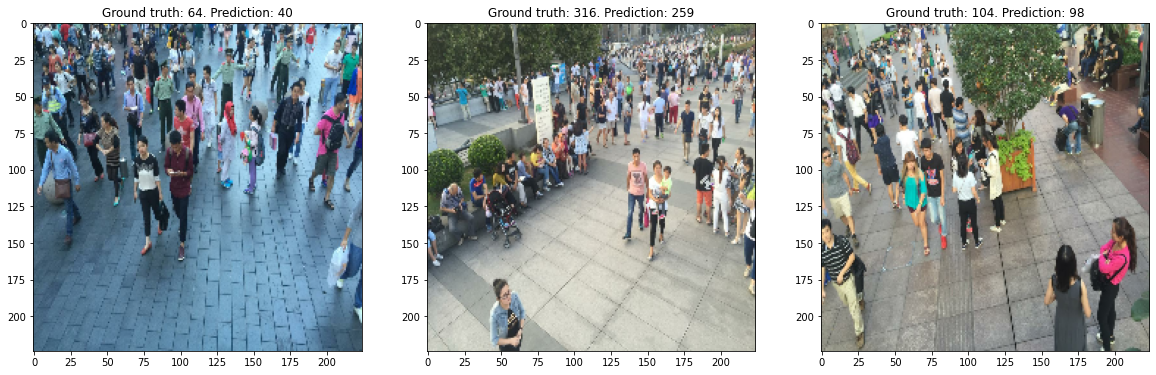

In [16]:
fig_pred = plt.figure(figsize=(20,10))

list_samples = list(test_ds.take(1).as_numpy_iterator())[0]
images = list_samples[0][:3]
labels = list_samples[1][:3]

labels_pred = fpn_121.predict(images).squeeze()

for i, image in enumerate(images):
    _ = plt.subplot(1,3,i+1)
    _ = plt.imshow(image)
    _ = plt.title('Ground truth: '+ str(labels[i])+'. Prediction: '+str(int(labels_pred[i])))
plt.show()
fig_pred.savefig('Shanghai part B fpn_121 prediction.png')

In [17]:
fpn_169 = CrowdCountingFPN(version='169').get_model()
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath='./best_FPN_169.h5', monitor='mae', verbose=1, save_best_only=True,
                save_weights_only=True, mode='min')
    
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=1e-6, verbose=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
fpn_169.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
hist_fpn_169 = fpn_169.fit(train_ds,
                    epochs=200, verbose=2, callbacks=[ckpt_callback, reduce_lr])

Epoch 1/200
13/13 - 18s - loss: 14004.0264 - mae: 83.7791

Epoch 00001: mae improved from inf to 83.77910, saving model to ./best_FPN_169.h5
Epoch 2/200
13/13 - 3s - loss: 3074.9597 - mae: 39.0265

Epoch 00002: mae improved from 83.77910 to 39.02654, saving model to ./best_FPN_169.h5
Epoch 3/200
13/13 - 3s - loss: 3029.4226 - mae: 35.9373

Epoch 00003: mae improved from 39.02654 to 35.93732, saving model to ./best_FPN_169.h5
Epoch 4/200
13/13 - 3s - loss: 1846.8955 - mae: 29.2652

Epoch 00004: mae improved from 35.93732 to 29.26516, saving model to ./best_FPN_169.h5
Epoch 5/200
13/13 - 3s - loss: 1714.3381 - mae: 25.9079

Epoch 00005: mae improved from 29.26516 to 25.90794, saving model to ./best_FPN_169.h5
Epoch 6/200
13/13 - 3s - loss: 3110.7585 - mae: 37.0830

Epoch 00006: mae did not improve from 25.90794
Epoch 7/200
13/13 - 3s - loss: 1820.0629 - mae: 30.3065

Epoch 00007: mae did not improve from 25.90794
Epoch 8/200
13/13 - 3s - loss: 1958.0024 - mae: 29.7674

Epoch 00008: mae d

In [18]:
fpn_169.load_weights('./best_FPN_169.h5')
fpn_169.evaluate(test_ds)

10/10 [==============================] - 3s 82ms/step - loss: 1364.9963 - mae: 22.5697


[1364.996337890625, 22.56974220275879]

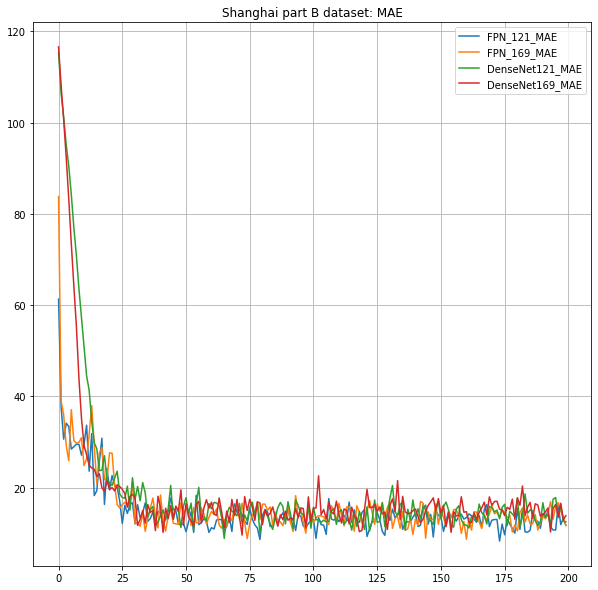

In [19]:
fig_train = plt.figure(figsize=(10,10))
plt.plot(hist_fpn_121.history['mae'], label='FPN_121_MAE')
plt.plot(hist_fpn_169.history['mae'], label='FPN_169_MAE')
plt.plot(hist_121.history['mae'], label='DenseNet121_MAE')
plt.plot(hist_169.history['mae'], label='DenseNet169_MAE')
plt.legend()
plt.grid()
plt.title('Shanghai part B dataset: MAE')

plt.show()
fig_train.savefig('Shanghai part B train plots.png')